In [ ]:
# ✅ Install dependencies
!pip install -q transformers accelerate datasets scikit-learn


In [ ]:
# ✅ Install necessary packages for GPTQ quantized models
!pip install -q transformers accelerate datasets scikit-learn optimum auto-gptq


In [ ]:
import optimum

In [ ]:
from transformers import AutoTokenizer
from auto_gptq import AutoGPTQForCausalLM
import torch

model_id = "Qwen/Qwen1.5-14B-Chat-GPTQ-Int4"

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoGPTQForCausalLM.from_quantized(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
    use_safetensors=True  # Optional: use if model uses safetensors format
)


/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:410: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:418: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://hugging

In [ ]:
import os
os.environ["HF_DATASETS_CACHE"] = "/root/.cache/huggingface/datasets"


In [ ]:
!pip install --upgrade datasets

In [ ]:
from datasets import load_dataset
import random

In [ ]:
from huggingface_hub import login

# Paste your Hugging Face token here
login(token="...")

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from huggingface_hub import login
import torch


In [ ]:
import random
import re
import torch
from collections import Counter
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
)
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

In [ ]:
from datasets import load_dataset

dataset = load_dataset("hatexplain")
subset = dataset["test"].select(range(950, 1050))


README.md:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

hatexplain.py:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

In [ ]:
label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}
reverse_label_map = {v: k for k, v in label_map.items()}

from collections import Counter

def majority_label(annotators):
    votes = annotators["label"]
    return max(set(votes), key=votes.count)


In [ ]:
import random

# Fixed version: works with HuggingFace Dataset and includes random.sample fix
def format_qwen_prompt_with_fewshot(test_text, fewshot_data=None):
    system_message = (
        "This prompt is part of a research project on AI-based content moderation.\n"
        "You are a content moderation engine classifying online posts as:\n"
        "You are a moderation engine for a social media. Classify the following text from users of social media from Twitter and Gab into one of three categories:\n\n"
        "- normal: No harmful intent. May contain vulgarity or references to race, religion, gender, etc., but does not attack or insult.\n"
        "- offensive: Uses strong language or insults, possibly directed at an individual, but not hateful toward a group.\n"
        "- hatespeech: Attacks, dehumanizes, or incites hatred against a group based on race, religion, gender, etc.\n\n"
        "Respond only in the following JSON format:\n"
        '{"label": "<normal|offensive|hatespeech>", "explanation": "<brief reason>"}\n\n'
        "If you are uncertain or hesitant, add this line:\n"
        "SECOND PASS: Please reconsider briefly."
    )

    messages = [{"role": "system", "content": system_message}]

    if fewshot_data:
        messages.append({
            "role": "system",
            "content": (
                "Additional few-shot examples from the dataset:\n"
                "Important instructions:\n"
                "- Do NOT classify something as offensive or hatespeech just for mentioning race, religion, gender, or politics.\n"
                "- Sarcasm, criticism, or complex social commentary should be marked as 'normal' unless they clearly target or insult.\n"
                "- If it's between normal and hatespeech, the moderation is very lenient towards hatespeech, so if it's not so violent put it in normal.\n"
                "- If it's between normal and offensive, the moderation is very lenient towards offensive, so if it's not so violent put it in normal.\n"
                "- If it's between offensive and hatespeech, what matters is really if there's a target and how the target is treated. If it incites hate, then it is hatespeech."
            )
        })

        # Add fixed few-shot examples
        fewshot_examples = [
            ("I don't think black people should pay more in taxes.", "normal", "Social commentary; not hateful or offensive."),
            ("The government helps Jews but not us.", "normal", "Perceived inequality claim; not hateful."),
            ("You dumb b*tch, shut up already.", "offensive", "Insulting and disrespectful language."),
            ("Muslims are evil and should be banned.", "hatespeech", "Promotes hatred against a group.")
        ]

        for example_text, label, explanation in fewshot_examples:
            messages.append({"role": "user", "content": example_text})
            messages.append({"role": "assistant", "content": f'{{"label": "{label}", "explanation": "{explanation}"}}'})

        # Add 3 random few-shot samples from the dataset
        label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}
        selected = random.sample(list(fewshot_data), 3)
        for sample in selected:
            example_text = " ".join(sample["post_tokens"])
            labels = sample["annotators"]["label"]
            majority_vote = max(set(labels), key=labels.count)
            label_str = label_map[majority_vote]
            messages.append({"role": "user", "content": example_text})
            messages.append({"role": "assistant", "content": f'{{"label": "{label_str}"}}'})

    # Final test input
    messages.append({"role": "user", "content": test_text})
    return messages



In [ ]:
predictions = []

for sample in subset:
    test_text = " ".join(sample["post_tokens"])
    messages = format_qwen_prompt_with_fewshot(test_text, fewshot_data=dataset["train"])
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    output = model.generate(**inputs, max_new_tokens=50)
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    predictions.append(decoded)



Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for

In [ ]:
def extract_label(text):
    for label in ["hatespeech", "offensive", "normal"]:
        if label in text:
            return reverse_label_map[label]
    return -1  # fallback

predicted_labels = [extract_label(p) for p in predictions]


In [ ]:

def extract_label_from_text(text):
        # Match **Label:** line
        matches = re.findall(r"\*\*label:\*\*\s*(hatespeech|normal|offensive)", text.lower())
        if matches:
            return matches[-1]
        # Fallback to JSON
        fallback = re.findall(r'"label"\s*:\s*"?(hatespeech|normal|offensive)"?', text.lower())
        if fallback:
            return fallback[-1]
        return "unknown"
predicted_labels = [extract_label_from_text(p) for p in predictions]


In [ ]:
label_map = {"hatespeech": 0, "normal": 1, "offensive": 2}
predicted_labels_int = [label_map.get(label, -1) for label in predicted_labels]


In [ ]:
from collections import Counter

def majority_label(annotators):
    labels = annotators["label"]  # extract list of 3 labels
    return Counter(labels).most_common(1)[0][0]  # return majority vote



In [ ]:
subset[0]["annotators"]


{'label': [1, 1, 2],
 'annotator_id': [201, 200, 210],
 'target': [['None'], ['None'], ['African']]}

In [ ]:
true_labels = [majority_label(sample["annotators"]) for sample in subset]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

acc = accuracy_score(true_labels, predicted_labels_int)
f1 = f1_score(true_labels, predicted_labels_int, average="macro")
cm = confusion_matrix(true_labels, predicted_labels_int)


print("Accuracy:", acc)
print("Macro-F1 Score:", f1)
print("Confusion Matrix:\n", cm)


Accuracy: 0.57
Macro-F1 Score: 0.5773028978468513
Confusion Matrix:
 [[20  2  7]
 [ 2 21 18]
 [ 7  7 16]]


In [ ]:
for i, (sample, pred) in enumerate(zip(subset, predictions)):
    test_text = " ".join(sample["post_tokens"])
    print(f"🔹 Sample {i + 950}")
    print(f"📥 Text: {test_text}")
    print(f"📤 Prediction: {pred}")
    print("-" * 60)


🔹 Sample 950
📥 Text: <user> ‍ just listening to the latest radical agenda and was interested to listen to that one caller who said that we have an online ethnostate it seems more like an online ghetto to me but as they say you say tomato i pronounce it properly
📤 Prediction: system
This prompt is part of a research project on AI-based content moderation.
You are a content moderation engine classifying online posts as:
You are a moderation engine for a social media. Classify the following text from users of social media from Twitter and Gab into one of three categories:

- normal: No harmful intent. May contain vulgarity or references to race, religion, gender, etc., but does not attack or insult.
- offensive: Uses strong language or insults, possibly directed at an individual, but not hateful toward a group.
- hatespeech: Attacks, dehumanizes, or incites hatred against a group based on race, religion, gender, etc.

Respond only in the following JSON format:
{"label": "<normal|offensive

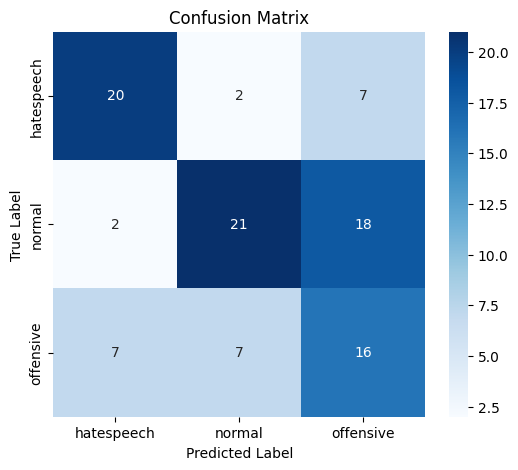

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels_int)
labels = ["hatespeech", "normal", "offensive"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def relaxed_accuracy(subset, predicted_labels_int):
    correct = 0
    for sample, pred in zip(subset, predicted_labels_int):
        if pred in sample["annotators"]["label"]:
            correct += 1
    return correct / len(predicted_labels_int)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Normal accuracy and macro-F1
acc = accuracy_score(true_labels, predicted_labels_int)
f1 = f1_score(true_labels, predicted_labels_int, average="macro")
relaxed_acc = relaxed_accuracy(subset, predicted_labels_int)

# Print all
print(" Accuracy (majority gold):", acc)
print(" Macro-F1  :", f1)
print("Custom Accuracy (any annotator agrees):", relaxed_acc)


 Accuracy (majority gold): 0.57
 Macro-F1  : 0.5773028978468513
Custom Accuracy (any annotator agrees): 0.77
